
# library

In [72]:
import warnings
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold

import optuna
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb 

from sklearn.metrics import mean_absolute_error


%matplotlib inline
warnings.filterwarnings('ignore')

# data load

빠른 학습을 위해 parquet 형태로 변환

In [22]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./data/{save_name}.parquet')
    del df 
    gc.collect()
    print(save_name, 'Done.')

csv_to_parquet('./data/train.csv', 'train')
csv_to_parquet('./data/test.csv', 'test')

In [25]:
data_info = pd.read_csv('./data/data_info.csv')
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [26]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [28]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   lane_count             291241 non-null  int64  
 5   road_rating            291241 non-null  int64  
 6   road_name              291241 non-null  object 
 7   multi_linked           291241 non-null  int64  
 8   connect_code           291241 non-null  int64  
 9   maximum_speed_limit    291241 non-null  float64
 10  vehicle_restricted     291241 non-null  float64
 11  weight_restricted      291241 non-null  float64
 12  height_restricted      291241 non-null  float64
 13  road_type              291241 non-null  int64  
 14  start_node_name        291241 non-nu

# EDA

#### 각 컬럼의 카테고리 개수 확인

In [30]:
column_names = train.columns.values.tolist()

for i in column_names:
    print(f"{i} = {train[i].nunique()}")

id = 4701217
base_date = 281
day_of_week = 7
base_hour = 24
lane_count = 3
road_rating = 3
road_name = 61
multi_linked = 2
connect_code = 2
maximum_speed_limit = 6
vehicle_restricted = 1
weight_restricted = 4
height_restricted = 1
road_type = 2
start_node_name = 487
start_latitude = 586
start_longitude = 586
start_turn_restricted = 2
end_node_name = 487
end_latitude = 586
end_longitude = 586
end_turn_restricted = 2
target = 102


#### 날짜/시간/요일별 target 추이 그래프

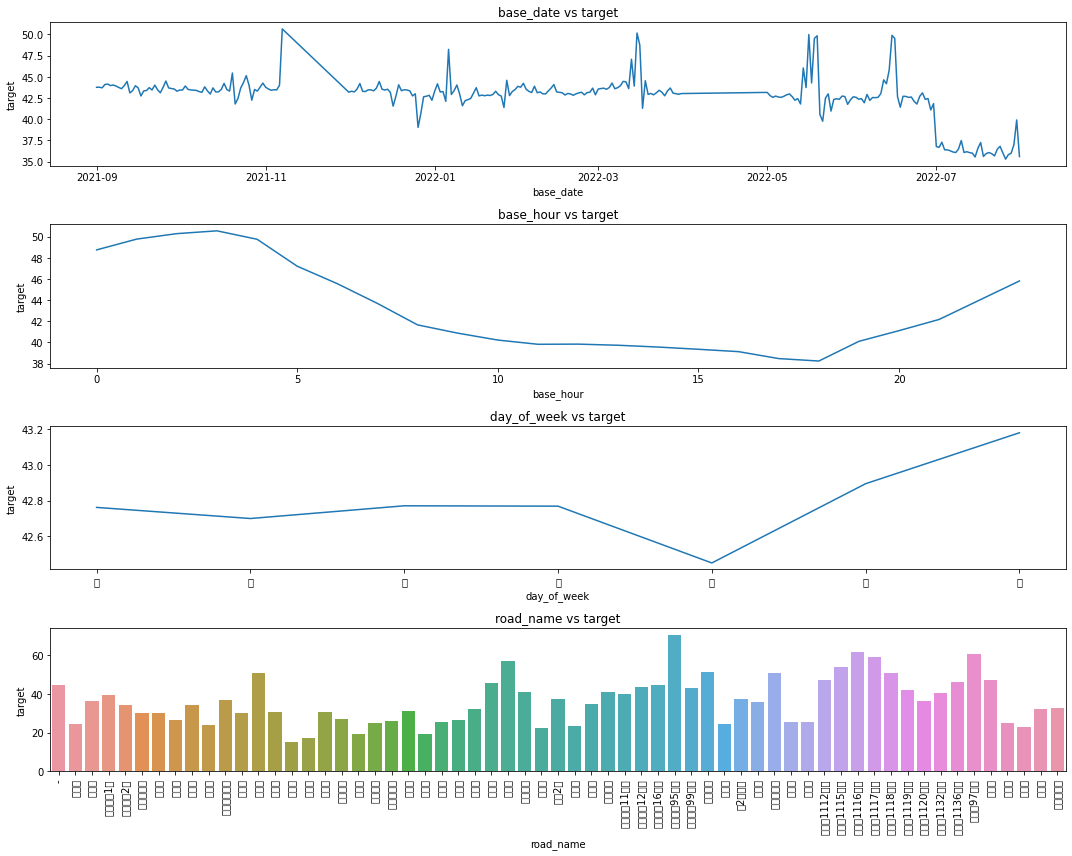

In [31]:
train['base_date'] = pd.to_datetime(train['base_date'], format = '%Y%m%d')

train_date = train[['base_date', 'target']]
train_date = train_date.groupby('base_date').mean().reset_index()

train_time = train[['base_hour', 'target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week', 'target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_name = train[['road_name', 'target']]
train_name = train_name.groupby('road_name').mean().reset_index()

fig, axes = plt.subplots(4, figsize=(15,12))

sns.lineplot(x='base_date', y='target', data=train_date, ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour', y='target', data=train_time, ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week', y='target', data=train_day, ax=axes[2]).set(title='day_of_week vs target')
sns.barplot(x='road_name', y='target', data=train_name, ax=axes[3]).set(title='road_name vs target')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### 월별 target

<AxesSubplot:xlabel='month', ylabel='target'>

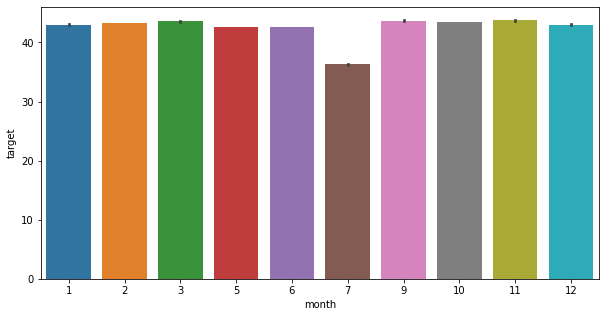

In [32]:
train["month"] = train["base_date"].dt.month

plt.figure(figsize=(10,5))
sns.barplot(x="month", y="target", data=train)

#### 계절별 target

<AxesSubplot:xlabel='season', ylabel='target'>

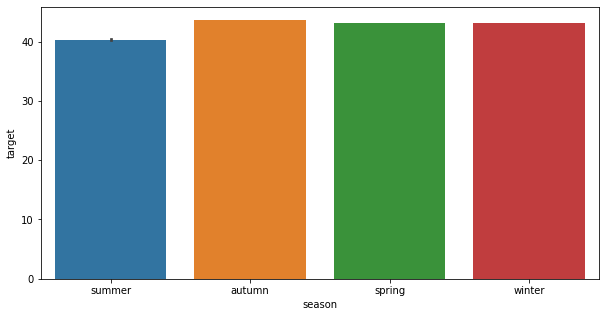

In [33]:
train['season'] = '-'
train.loc[(train['month'] == 3) | (train['month'] == 4) | (train['month'] == 5), 'season'] = 'spring'
train.loc[(train['month'] == 6) | (train['month'] == 7) | (train['month'] == 8), 'season'] = 'summer'
train.loc[(train['month'] == 9) | (train['month'] == 10) | (train['month'] == 11), 'season'] = 'autumn'
train.loc[(train['month'] == 12) | (train['month'] == 1) | (train['month'] == 2), 'season'] = 'winter'
train.loc[(train['season']=='-'), 'season'] = 'Na' 

plt.figure(figsize=(10,5))
sns.barplot(x="season", y="target", data=train)

#### 시간대별 target

<AxesSubplot:xlabel='group_time', ylabel='target'>

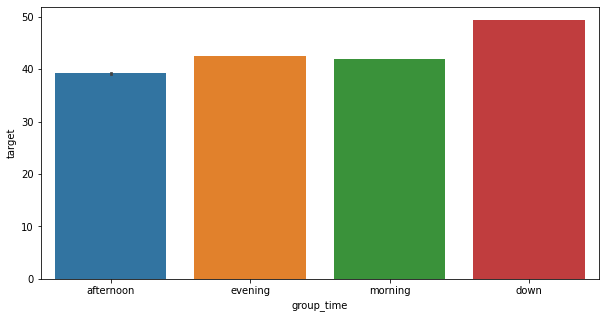

In [34]:
train['group_time'] = '-'
train.loc[(train['base_hour'] < 6), 'group_time'] = 'down'
train.loc[(train['base_hour'] >= 6) & (train['base_hour'] < 12), 'group_time'] = 'morning'
train.loc[(train['base_hour'] >=12) & (train['base_hour'] < 19), 'group_time'] = 'afternoon'
train.loc[(train['base_hour'] >= 19) & (train['base_hour'] <= 24), 'group_time'] = 'evening'
train.loc[(train['group_time'] == '-'), 'group_time'] = 'Na'

plt.figure(figsize=(10,5))
sns.barplot(x='group_time', y='target', data=train)

#### 최고 제한 속도(maximum_speed_limit)

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='target'>

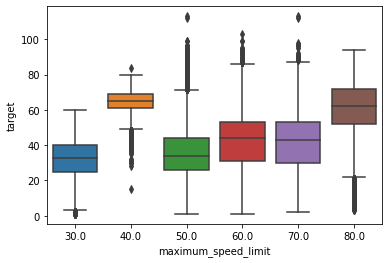

In [35]:
sns.boxplot(x="maximum_speed_limit", y="target", data=train)

- 최대 제한 속도에 따라 평균값의 차이가 다름 
- 이상치 중에서도 값의 차이가 많이 나는 값들이 있음

#### 차로 수(lane_count)

<AxesSubplot:xlabel='lane_count', ylabel='target'>

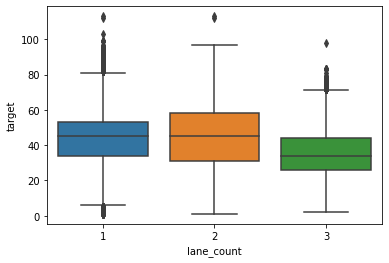

In [36]:
sns.boxplot(x=train.lane_count, y=train.target)

- 2차선일 때 가장 빠른 속도를 보였고, 3차선일 때 가장 느린 속도를 보임

#### 통과 제한 하중(weight_restricted)

<AxesSubplot:xlabel='weight_restricted', ylabel='target'>

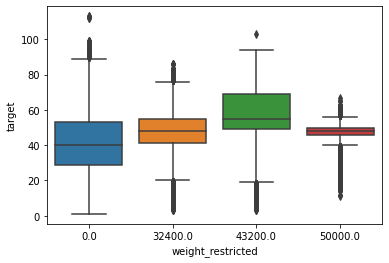

In [37]:
sns.boxplot(x="weight_restricted", y="target", data=train)

- 제한 하중이 없는 경우 평균 속도가 가장 낮음

#### 도로 등급(road_rating)
- 103 : 일반 국도
- 106 : 지방도
- 107 : 시도, 군도

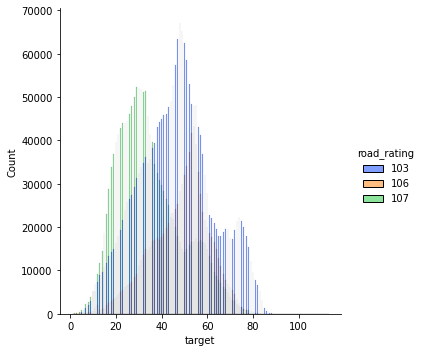

In [38]:
sns.displot(x=train.target, hue=train.road_rating, palette="bright")

- 도로등급이 106(지방도), 103(일반국도)일 때 평균적으로 높은 속도를 보임, 107(시도, 군도)은 낮은 평균 속도
- 최대값에서도 도로등급 107(시도, 군도)가 가장 낮은 속도를 보임

In [40]:
train.drop(['month', 'season', 'group_time'], axis=1, inplace=True)

# preprocessing

### road_name("-") 대체

- road_rating(도로등급)과 weight_restricted(통과제한하중) 변수를 사용하여 약 8만 7천개의 결측값 대체 
- weight_restricted = 32400.0, 43200.0

In [42]:
print('대체 전:',len(train[train["road_name"] == "-"]))

train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0) & (train["road_name"] == "-"), "road_name"] = "산서로"

test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 43200.0) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 32400.0) & (test["road_name"] == "-"), "road_name"] = "산서로"

print('대체 후:',len(train[train["road_name"] == "-"]))

대체 전: 569463
대체 후: 481943


- weight_restricted = 0.0인 경우, start_node_name(시작지점명)에서 road_name이 "-"을 포함해서 2가지인 경우를 출력해서 약 10만개의 결측값 대체

In [43]:
# 결측값 대체 함수 생성

def make_list(feature):
    lst = [] 
    for i in train[feature].unique():
        if len(train[train[feature] == i]["road_name"].value_counts()) != 2:
            continue
        if "-" in train[train[feature] == i]["road_name"].value_counts().index:
            index = train[train[feature] == i]["road_name"].value_counts().index.tolist()
            index.remove("-")
            lst.append([i, index[0]])
    return lst

def replace_func(feature):
    lst = make_list(feature)
    
    # train 
    for re_lst in lst:
        train.loc[(train[feature] == re_lst[0]) & (train["road_name"] == "-"), "road_name"] = re_lst[1]
    print('대체 후:', len(train[train["road_name"] == "-"]))
    
    # test
    for re_lst in lst:
        test.loc[(test[feature] == re_lst[0]) & (test["road_name"] == "-"), "road_name"] = re_lst[1]    

In [44]:
replace_func("start_node_name")

대체 후: 379668


- end_node_name(도착지점명)에서 road_name이 "-"을 포함해서 2가지인 경우를 출력해서 약 10만개의 결측값 대체

In [45]:
replace_func("end_node_name")

대체 후: 277900


- 위도, 경도 변수 사용하여 값 대체

In [46]:
# 위도, 경도 소숫점 자릿수 제한(7번째 자리에서 반올림)

print(train["start_latitude"].nunique(), train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique()) 

train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x : round(x, 6))
test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x : round(x, 6))

print(train["start_latitude"].nunique(), train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique()) 

586 586 586 586
586 586 586 586


In [47]:
replace_func("start_latitude") # 시작지점의 위도

대체 후: 228095


In [48]:
replace_func("end_latitude") # 도착지점의 위도

대체 후: 205952


In [49]:
replace_func("start_longitude") # 시작지점의 경도

대체 후: 197539


In [50]:
replace_func("end_longitude") # 도착지점의 경도

대체 후: 188647


- 두 개 이상의 항목 탐색 -> 종료지점 중심
- end_logitude, end_latitude, lane_count 사용

In [51]:
temp_train = train.groupby(["end_longitude", "end_latitude", "lane_count"])[["road_name"]].sum()
temp_train = temp_train.agg({"road_name":pd.Series.mode})

long_lat = [] 

for i in range(len(temp_train)):
    if "-" in temp_train["road_name"].iloc[i][0]:
        long_lat.append(temp_train.index[i])
    
for i in range(len(long_lat)):
    if len(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

-      5928
중문로    5881
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
-      6057
애조로    6048
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [52]:
print('대체 전:', len(train[train["road_name"] == "-"]))

train.loc[(train["end_longitude"] == 126.414236) & (train["end_latitude"] == 33.255215) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_longitude"] == 126.456384) & (train["end_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["end_longitude"] == 126.414236) & (test["end_latitude"] == 33.255215) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_longitude"] == 126.456384) & (test["end_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

print('대체 후:', len(train[train["road_name"] == "-"]))

대체 전: 188647
대체 후: 176662


- 두 개 이상의 항목 탐색 -> 시작지점 중심
- start_longitude, start_latitude, lane_count 사용

In [53]:
temp_train = train.groupby(["start_longitude", "start_latitude", "lane_count"])[["road_name"]].sum()
temp_train = temp_train.agg({"road_name":pd.Series.mode})

long_lat = [] 

for i in range(len(temp_train)):
    if "-" in temp_train["road_name"].iloc[i][0]:
        long_lat.append(temp_train.index[i])
    
for i in range(len(long_lat)):
    if len(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

산서로    4454
-      4228
Name: road_name, dtype: int64
126.261797 33.415529 2
------------------------------
산서로    4438
-      4360
Name: road_name, dtype: int64
126.262739 33.415854 2
------------------------------
중문로    5928
-      5853
Name: road_name, dtype: int64
126.413687 33.255431 2
------------------------------
-    5899
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
애조로    6057
-      6034
Name: road_name, dtype: int64
126.454583 33.466433 2
------------------------------
애조로    6044
-      6034
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [54]:
print('대체 전:', len(train[train["road_name"] == "-"]))

train.loc[(train["start_longitude"] == 126.261797) & (train["start_latitude"] == 33.415529) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_longitude"] == 126.262739) & (train["start_latitude"] == 33.415854) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_longitude"] == 126.413687) & (train["start_latitude"] == 33.255431) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_longitude"] == 126.454583) & (train["start_latitude"] == 33.466433) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"
train.loc[(train["start_longitude"] == 126.456384) & (train["start_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["start_longitude"] == 126.261797) & (test["start_latitude"] == 33.415529) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_longitude"] == 126.262739) & (test["start_latitude"] == 33.415854) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_longitude"] == 126.413687) & (test["start_latitude"] == 33.255431) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_longitude"] == 126.454583) & (test["start_latitude"] == 33.466433) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"
test.loc[(test["start_longitude"] == 126.456384) & (test["start_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

print('대체 후:', len(train[train["road_name"] == "-"]))

대체 전: 176662
대체 후: 150153


### target outlier

In [56]:
train = train[train.target<100]
train.reset_index(drop=True, inplace=True)

### feature engineering

#### 시간 관련 파생변수

- 월 변수 추가

In [60]:
train["base_date"] = train["base_date"].astype(str)
train["base_date"] = pd.to_datetime(train["base_date"])

test["base_date"] = test["base_date"].astype(str)
test["base_date"] = pd.to_datetime(test["base_date"])

train["month"] = train["base_date"].dt.month
test["month"] = test["base_date"].dt.month

- 계절 변수 추가

In [61]:
train['season'] = '-'
train.loc[(train['month'] == 3) | (train['month'] == 4) | (train['month'] == 5), 'season'] = 'spring'
train.loc[(train['month'] == 6) | (train['month'] == 7) | (train['month'] == 8), 'season'] = 'summer'
train.loc[(train['month'] == 9) | (train['month'] == 10) | (train['month'] == 11), 'season'] = 'autumn'
train.loc[(train['month'] == 12) | (train['month'] == 1) | (train['month'] == 2), 'season'] = 'winter'
train.loc[(train['season'] == '-'), 'season'] = 'Na'

test['season'] = '-'
test.loc[(test['month'] == 3) | (test['month'] == 4) | (test['month'] == 5), 'season'] = 'spring'
test.loc[(test['month'] == 6) | (test['month'] == 7) | (test['month'] == 8), 'season'] = 'summer'
test.loc[(test['month'] == 9) | (test['month'] == 10) | (test['month'] == 11), 'season'] = 'autumn'
test.loc[(test['month'] == 12) | (test['month'] == 1) | (test['month'] == 2), 'season'] = 'winter'
test.loc[(test['season'] == '-'), 'season'] = 'Na'

- 시간대별 변수 추가

In [62]:
train['group_time'] = '-'
train.loc[(train['base_hour'] < 6), 'group_time'] = 'down'
train.loc[(train['base_hour'] >= 6) & (train['base_hour'] < 12), 'group_time'] = 'morning'
train.loc[(train['base_hour'] >= 12) & (train['base_hour'] < 19), 'group_time'] = 'afternoon'
train.loc[(train['base_hour'] >= 19) & (train['base_hour'] <=24), 'group_time'] = 'evening'
train.loc[(train['group_time'] == '-'), 'group_time'] = 'Na'

test['group_time'] = '-'
test.loc[(test['base_hour'] < 6), 'group_time'] = 'down'
test.loc[(test['base_hour'] >= 6) & (test['base_hour'] < 12), 'group_time'] = 'morning'
test.loc[(test['base_hour'] >= 12) & (test['base_hour'] < 19), 'group_time'] = 'afternoon'
test.loc[(test['base_hour'] >= 19) & (test['base_hour'] <=24), 'group_time'] = 'evening'
test.loc[(test['group_time'] == '-'), 'group_time'] = 'Na'

#### 공간 관련 파생변수

- 위도, 경도 차이 변수 추가

In [63]:
train['lat_change'] = train['start_latitude'] - train['end_latitude']
train['lon_change'] = train['start_longitude'] - train['end_longitude']

test['lat_change'] = test['start_latitude'] - test['end_latitude']
test['lon_change'] = test['start_longitude'] - test['end_longitude']

- 두 지점 사이의 거리(haversine 공식 사용)

In [64]:
from math import radians, cos, sin, asin, sqrt

def haversine(row):
    
    # convert decimal degrees to radians
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    
    return km

train['distance'] = train.apply(haversine, axis=1)
test['distance'] = test.apply(haversine, axis=1)

### label encodiing

In [67]:
str_col = ["day_of_week", "road_rating", "road_name", "maximum_speed_limit", "weight_restricted", 
           "road_type", "start_node_name", "start_turn_restricted", "end_node_name", "end_turn_restricted", "season", "group_time"]

for i in str_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

### 불필요한 변수 제거

In [74]:
y_train = train["target"]
X_train = train.drop(["id", "base_date", "multi_linked", "connect_code", "vehicle_restricted", "height_restricted", "target"], axis=1)
X_test = test.drop(["id", "base_date", "multi_linked", "connect_code", "vehicle_restricted", "height_restricted"], axis=1)

### StandardScaling

In [76]:
col = X_train.columns

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col)
X_test = pd.DataFrame(X_test, columns=col)

# Hyperparameter tuning -> Optuna

- KNN

In [ ]:
# def objective(trial, data=X_train, target=y_train):
    
#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=2022)
    
#     param = {
#         'n_neighbors' : trial.suggest_int('n_neighbors', 1, 60),
#         'weights' : trial.suggest_categorical('weights', ['uniform','distance']),
#         'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
#         'n_jobs' : -1
#         }
    
#     model = KNeighborsRegressor(**param)
#     model.fit(X_train, y_train)
        
#     pred = model.predict(X_valid)    
#     mae = mean_absolute_error(y_valid, pred)
    
#     return mae

# study = optuna.create_study(direction= 'minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

- RandomForest

In [ ]:
# def objective(trial, data=X_train, target=y_train):
    
#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=2022)
    
#     param = {
#         'max_depth' : trial.suggest_int('max_depth', 1, 30),
#         'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 1, 1000),
#         'n_estimators' : trial.suggest_int('n_estimators', 30, 1000)      
#     }
    
#     model = RandomForestRegressor(**param)
#     model.fit(X_train, y_train)
        
#     pred = model.predict(X_valid)    
#     mae = mean_absolute_error(y_valid, pred)
    
#     return mae

# study = optuna.create_study(direction= 'minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

- XGBoost

In [ ]:
# def objective(trial,data=X_train,target=y_train):
    
#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=2022)

#     param = {

#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
#         'n_estimators': 10000,
#         'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12,13,14,15]),
#         'random_state': trial.suggest_categorical('random_state', [1234]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 100, 1000),

#         'objective':'reg:squarederror',
#     }

#     model = XGBRegressor(**param)
    
#     model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=25,verbose=False)
    
#     pred = model.predict(X_valid)    
#     mae = mean_absolute_error(y_valid, pred)

#     return mae

# sampler = optuna.samplers.TPESampler(seed=10)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

- LightGBM

In [ ]:
# def objective(trial,data=X_train,target=y_train):
    
#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=2022)

#     param = {

#         'objective': 'regression',
#         'verbose': -1,
#         'metric': 'mae', 
#         'max_depth': trial.suggest_int('max_depth',3, 15),
#         'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
#         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
#     }

#     model = lgb.LGBMRegressor(**param)
    
#     model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=25)
    
#     pred = model.predict(X_valid)    
#     mae = mean_absolute_error(y_valid, pred)

#     return mae

# sampler = optuna.samplers.TPESampler(seed=10)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

- CatBoost

In [ ]:
# def objective(trial, data=X_train, target=y_train):

#     X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=2022)


#     param = {
#         'iterations':trial.suggest_int("iterations", 4000, 25000),
#         'od_wait':trial.suggest_int('od_wait', 500, 2300),
#         'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
#         'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
#         'subsample': trial.suggest_uniform('subsample',0,1),
#         'random_strength': trial.suggest_uniform('random_strength',10,50),
#         'depth': trial.suggest_int('depth',1, 15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
#         'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#         'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
#         'random_state' : 2022
#     }


#     model = CatBoostRegressor(**param)
#     model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=25)
                           
#     pred = model.predict(X_valid)    
#     mae = mean_absolute_error(y_valid, pred)

#     return mae

# sampler = optuna.samplers.TPESampler(seed=10)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(objective, n_trials=10)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

# modeling
- 최종 best score -> XGBoost + StratifiedKFold

In [77]:
X = X_train.copy()
y = y_train.copy()

In [78]:
def get_model(ml_model, params):
    if ml_model == "KNN":
        model = KNeighborsRegressor(**params, n_jobs=-1)
    elif ml_model == "RandomForest":
        model = RandomForestRegressor(**params)
    elif ml_model == "CatBoost":
        model = CatBoostRegressor(**params)
    elif ml_model == "LightGBM":
        model = lgb.LGBMRegressor(**params)
    elif ml_model == "XGBoost":
        model = XGBRegressor(**params)
    return model 

params = {
    
    "KNN" : {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'manhattan'},
    
    "RandomForest" : {'max_depth': 18, 'max_leaf_nodes': 907, 'n_estimators': 227},
        
    "CatBoost" : {'iterations': 22228, 'od_wait': 2007, 'learning_rate': 0.015621794068637028, 
                'reg_lambda': 83.75859340286098,'random_strength': 33.460726474577406,
                'depth': 13, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 5,
                 'bagging_temperature': 0.014299438084260483, 'task_type':'GPU', 'random_state' : 2022},
    
    "LightGBM" : {'learning_rate':0.05, 'max_depth':16,'boosting':'gbdt', 'objective':'regression', 'num_leaves':5000, 
                  'ramdom_state':2022, 'num_iterations':5000},
    
    "XGBoost" : {'n_estimators': 10000, 'lambda': 0.0010647391923787098, 'alpha': 0.007165643470571922, 'colsample_bytree': 0.7,
                'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 14, 'random_state': 1234, 'min_child_weight': 361, 
                 'objective':'reg:squarederror', 'tree_method':'gpu_hist', 'gpu_id':0}
        }

In [79]:
folds = []
ml_model = {}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2022)

for train_idx, val_idx in skf.split(X, y):
    folds.append((train_idx, val_idx))

    
for i in range(10):
    print(f'===================================={i+1}============================================')
    
    train_idx, val_idx = folds[i]
    
    x_train, x_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
    
    model = get_model("XGBoost", params["XGBoost"])
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"{i+1}Fold MAE = {mae}")
    
    ml_model[i] = model
    print(f'================================================================================\n\n')

====================================1============================================
1Fold MAE = 3.024058868328391


====================================2============================================
2Fold MAE = 3.022306747925834


====================================3============================================
3Fold MAE = 3.024278700006731


====================================4============================================
4Fold MAE = 3.0165316888538465


====================================5============================================
5Fold MAE = 3.0268170242324826


====================================6============================================
6Fold MAE = 3.0301392954047994


====================================7============================================
7Fold MAE = 3.02711162652927


====================================8============================================
8Fold MAE = 3.024005891162464


====================================9============================================
9Fol

feature importance

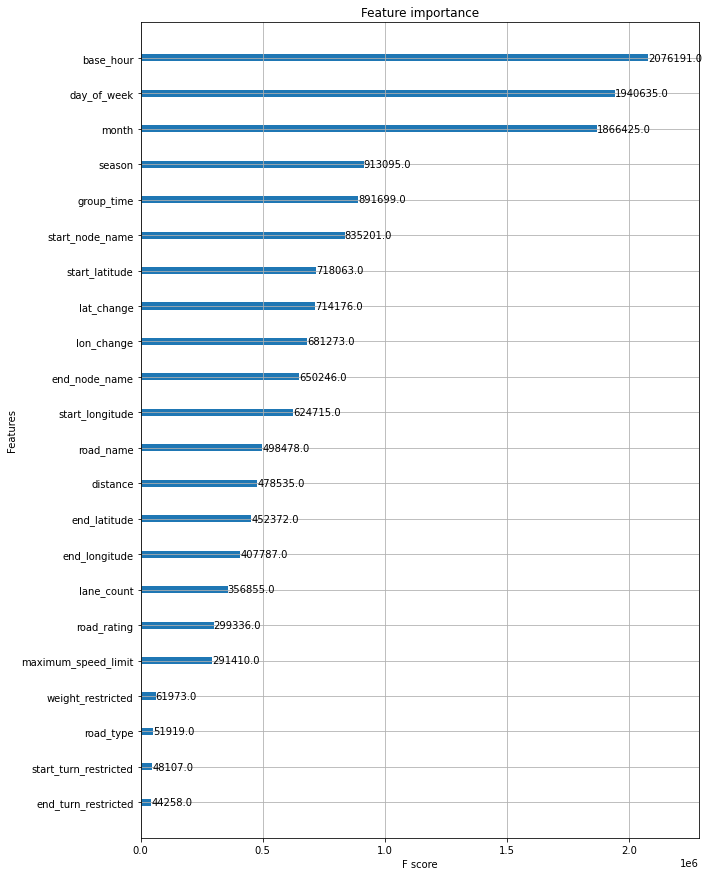

In [80]:
fig, ax = plt.subplots(figsize=(10,15))
ax = plot_importance(ml_model[0], max_num_features=len(col), ax=ax)

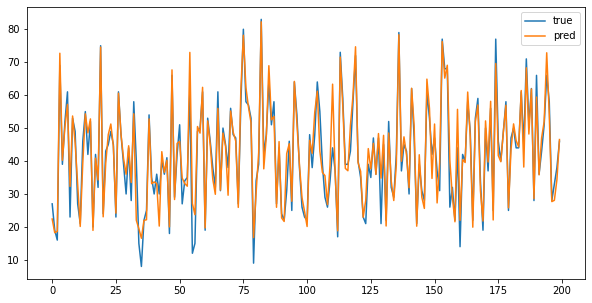

In [81]:
plt.figure(figsize=(10,5))

plt.plot(np.array(y_valid[300:500]), label='true')
plt.plot(y_pred[300:500], label='pred')
plt.legend()
plt.show()

# submission

In [82]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

for fold in range(10):
    sample_submission['target'] += ml_model[fold].predict(X_test)/10
    
sample_submission['target'] = round(sample_submission['target'])
sample_submission.to_csv('./submission/submit_total.csv', index=False)

----------------